In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(256),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)      
])

In [3]:
train_dir = 'dataset3/training_set/'
test_dir   = 'dataset3/test_set/'
train_dataset = datasets.ImageFolder(train_dir,data_transforms)
train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)

test_dataset = datasets.ImageFolder(test_dir,data_transforms)
test_loader = DataLoader(test_dataset,batch_size=4,shuffle=True)

print(f'Size of train_dataset = {len(train_dataset)}')
print(f'Size of test_dataset = {len(test_dataset)}')

Size of train_dataset = 8005
Size of test_dataset = 2023


In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


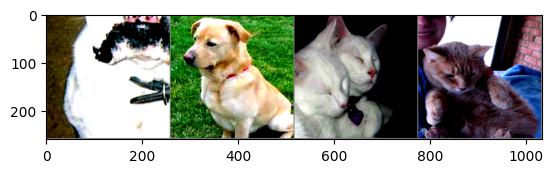

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


## Model Performance without changing the weights

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
def evaluate(model):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
    
        for idx,(inputs,labels) in enumerate(test_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _,predictions = torch.max(outputs,1)
            running_corrects += torch.sum(predictions == labels.data)
            # print(idx,running_corrects)

    model_acc = running_corrects/len(test_dataset)
    print(f'Accuracy: {model_acc}')
    return


In [15]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

C:\Users\athar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\athar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
PATH = 'dcModel_89%.pth'
model.load_state_dict(torch.load(PATH))
evaluate(model)

Accuracy: 0.9649035334587097


In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Training phase
        model.train()
        running_loss = 0
        running_corrects =0

        # Iterate over data.
        for idx,(inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # print(outputs)
            _,predictions = torch.max(outputs,1)
            # print(predictions)
            loss = criterion(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(predictions == labels.data)

            if (idx+1) % 100 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        scheduler.step()
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        
        print (f'Epoch [{epoch+1}/{num_epochs}], Accuracy : {epoch_acc}, Best Accuracy: {best_acc}')


        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Finished Training')
    model.load_state_dict(best_model_wts)
    PATH = './dcModel.pth'
    torch.save(model.state_dict(), PATH)

    return model

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch [1/25], Step [100/2002], Loss: 0.0758
Epoch [1/25], Step [200/2002], Loss: 0.0790
Epoch [1/25], Step [300/2002], Loss: 0.1145
Epoch [1/25], Step [400/2002], Loss: 0.2499
Epoch [1/25], Step [500/2002], Loss: 0.3172
Epoch [1/25], Step [600/2002], Loss: 0.4617
Epoch [1/25], Step [700/2002], Loss: 0.1908
Epoch [1/25], Step [800/2002], Loss: 0.4455
Epoch [1/25], Step [900/2002], Loss: 0.3203
Epoch [1/25], Step [1000/2002], Loss: 1.1366
Epoch [1/25], Step [1100/2002], Loss: 0.4217
Epoch [1/25], Step [1200/2002], Loss: 0.0924
Epoch [1/25], Step [1300/2002], Loss: 0.4348
Epoch [1/25], Step [1400/2002], Loss: 0.0071
Epoch [1/25], Step [1500/2002], Loss: 0.5511
Epoch [1/25], Step [1600/2002], Loss: 0.1736
Epoch [1/25], Step [1700/2002], Loss: 0.0231
Epoch [1/25], Step [1800/2002], Loss: 0.1714
Epoch [1/25], Step [1900/2002], Loss: 0.3260
Epoch [1/25], Step [2000/2002], Loss: 0.0697
Epoch [1/25], Accuracy : 0.8959400374765771, Best Accuracy: 0.0
Epoch [2/25], Step [100/2002], Loss: 0.1396
E

In [20]:
PATH = 'dcModel_TL.pth'
model.load_state_dict(torch.load(PATH))
model = model.to(device)
evaluate(model)

Accuracy: 0.9713296294212341


: 